# Titanic - Feature Engineering

## Preparation

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Load dataset

In [2]:
df = pd.read_csv('./data/exp1_train.csv')
df_test = pd.read_csv('./data/exp1_test.csv')
print("Successfully load preprocessed data.")

Successfully load preprocessed data.


In [3]:
df.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name    

In [4]:
for x in ['Pclass', 'Sex', 'Embarked']:
    df[x] = df[x].astype('category')
    df_test[x] = df_test[x].astype('category')
df['Survived'] = df['Survived'].astype('category')

## Addressing outliers

There are some famous techniques to handle outlier values (removing outliers, transforming data, imputation,...). 

At first, I decided to use imputation technique to replace outlier values with median of the column, as median is not affected by outlier values. However, after implementing that, I found out that we cannot remove all outlier values in `Fare` feature, as the number of outliers is quite high (116 outliers, which is about 13% of total rows).

Because of that, I decided to generate new features: `Age_bin` and `Fare_bin`, which categorize `Age`and `Fare` into different groups using `pd.qcut()`. 

For `Age_bin`, I categorized it into 7 groups: below 12, 12-18, 19-25, 26-32, 33-45, 46-60, and after 60.

For `Fare_bin`, I categorized it into 9 groups: low_minus, low, low_plus, medium_minus, medium, medium_plus, high_minus, high, and high_plus.

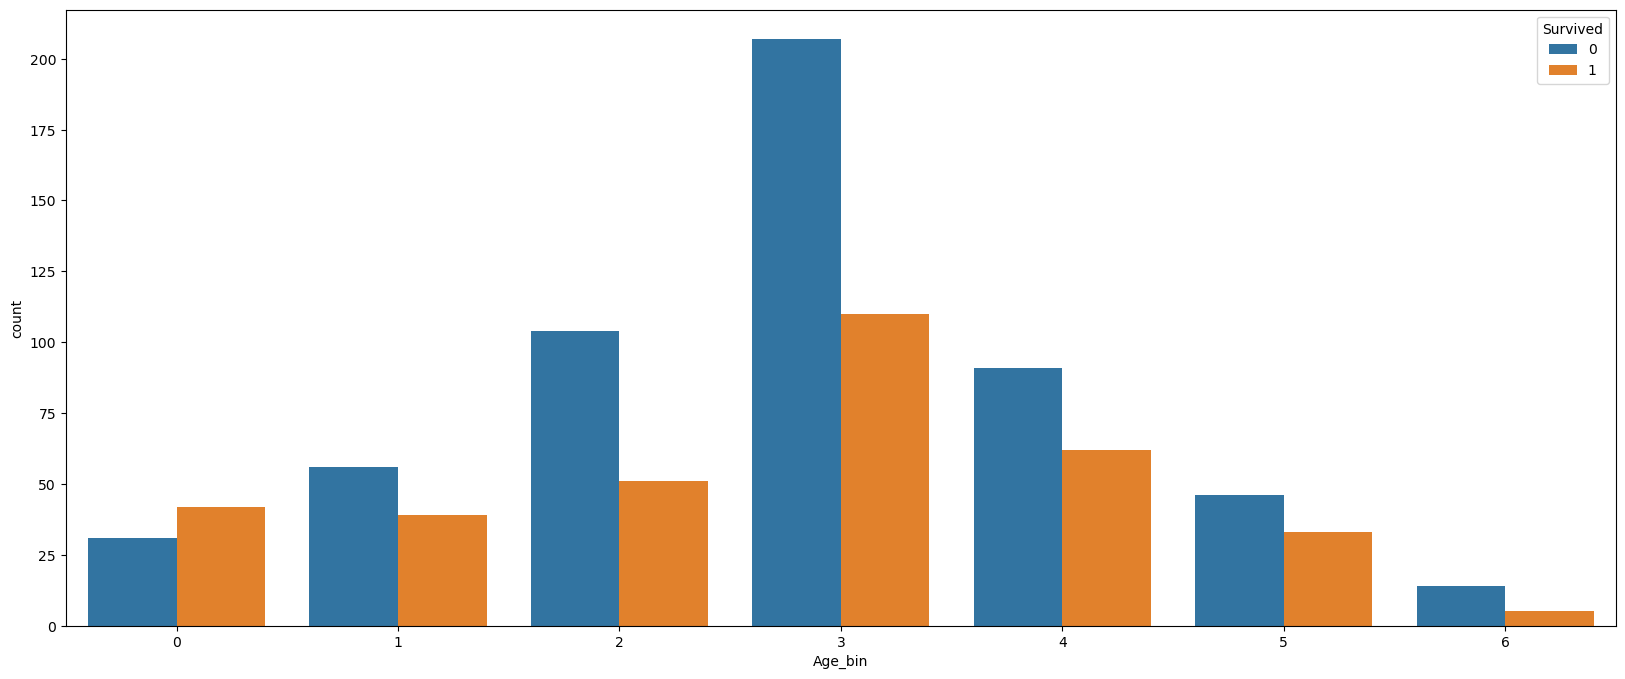

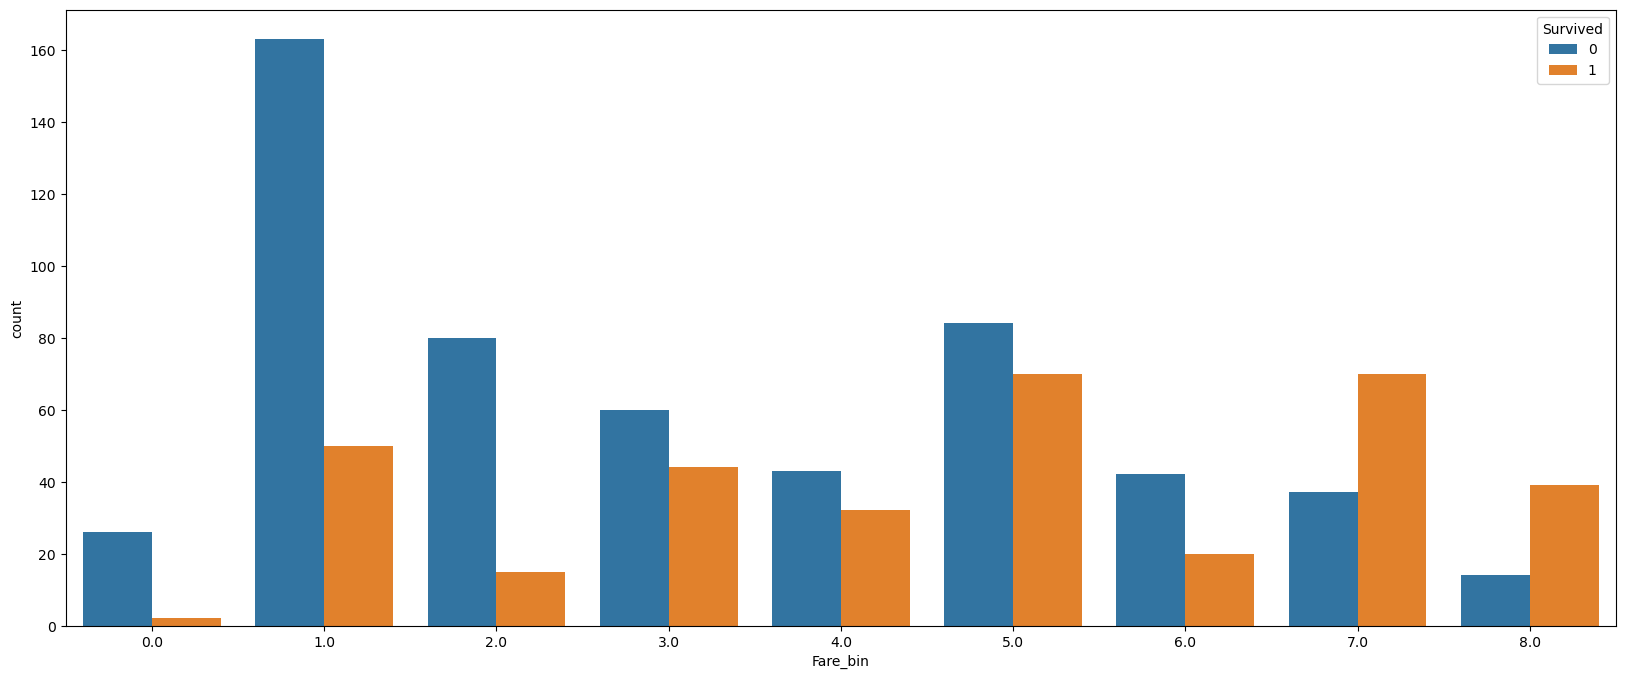

In [5]:
df['Age_bin'] = pd.cut(df['Age'], bins=[0, 12, 19, 26, 33, 46, 61, 100], labels=False)
df['Age_bin'] = df['Age_bin'].astype('category')
df_test['Age_bin'] = pd.cut(df_test['Age'], bins=[0, 12, 19, 26, 33, 46, 61, 100], labels=False)
df_test['Age_bin'] = df_test['Age_bin'].astype('category')

fig, axs = plt.subplots(figsize=(20, 8))
sns.countplot(x='Age_bin', hue='Survived', data=df)
plt.show()

df['Fare_bin'] = pd.cut(df['Fare'], bins=[0, 7, 8, 10, 14.45, 20, 31, 50, 100, 1000000], labels=False)
df_test['Fare_bin'] = pd.cut(df_test['Fare'], bins=[0, 7, 8, 10, 14.45, 20, 31, 50, 100, 1000000], labels=False)

missing_fare_bin = df[df['Fare_bin'].isnull() & (df['Fare'] == 0.0)]
df.loc[missing_fare_bin.index, 'Fare_bin'] = 0

missing_fare_bin_test = df_test[df_test['Fare_bin'].isnull() & (df_test['Fare'] == 0.0)]
df_test.loc[missing_fare_bin_test.index, 'Fare_bin'] = 0

df['Fare_bin'] = df['Fare_bin'].astype('category')
df_test['Fare_bin'] = df_test['Fare_bin'].astype('category')

fig, axs = plt.subplots(figsize=(20, 8))
sns.countplot(x='Fare_bin', hue='Survived', data=df)
plt.show()

On Age_bin's distribution:
-   0: below 12
-   1: 12-18
-   2: 19-25
-   3: 26-32
-   4: 33-45
-   5: 46-60
-   6: 61 and above

On Fare_bin's distribution: 0, 7, 8, 10, 14.45, 20, 31, 50, 100, 1000000
-  0: low_minus (below 7)
-  1: low (7-8)
-  2: low_plus (8-10)
-  3: medium_minus (10-14.45)
-  4: medium (14.45-20)
-  5: medium_plus (20-31)
-  6: high_minus (31-50)
-  7: high (50-100)
-  8: high_plus (above 100)

We can see that in Age_bin:
- Group 0 (below 12) is the only group that the number of survivors is higher than that of non-survivors.
- Group 3 (26-32) has the highest number of passengers.
- Group 3 (26-32) has the lowest survival rate compared to other groups.

In Fare_bin:
- Group 1 (7-8) has the highest number of passengers.
- Generally, the higher the fare, the higher the survival rate.

#### Survivability of each group based on Age_bin and Fare_bin

In [6]:
# survivability of each group based on Age_bin and Fare_bin
for age_bin in sorted(df['Age_bin'].unique()):
    survived = df[df['Age_bin'] == age_bin][df['Survived'] == 1]
    survive_percentage = len(survived) / len(df[df['Age_bin'] == age_bin]) * 100
    print(f'Age_bin {age_bin}: {survive_percentage:.2f}% survived')

for fare_bin in sorted(df['Fare_bin'].unique()):
    survived = df[df['Fare_bin'] == fare_bin][df['Survived'] == 1]
    try:
        survive_percentage = len(survived) / len(df[df['Fare_bin'] == fare_bin]) * 100
    except ZeroDivisionError:
        survive_percentage = -1
    print(f'Fare_bin {fare_bin}: {survive_percentage:.2f}% survived')

Age_bin 0: 57.53% survived
Age_bin 1: 41.05% survived
Age_bin 2: 32.90% survived
Age_bin 3: 34.70% survived
Age_bin 4: 40.52% survived
Age_bin 5: 41.77% survived
Age_bin 6: 26.32% survived
Fare_bin 0.0: 7.14% survived
Fare_bin 1.0: 23.47% survived
Fare_bin 2.0: 15.79% survived
Fare_bin 3.0: 42.31% survived
Fare_bin 4.0: 42.67% survived
Fare_bin 5.0: 45.45% survived
Fare_bin 6.0: 32.26% survived
Fare_bin 7.0: 65.42% survived
Fare_bin 8.0: 73.58% survived


/tmp/ipykernel_7984/3372129829.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  survived = df[df['Age_bin'] == age_bin][df['Survived'] == 1]
/tmp/ipykernel_7984/3372129829.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  survived = df[df['Age_bin'] == age_bin][df['Survived'] == 1]
/tmp/ipykernel_7984/3372129829.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  survived = df[df['Age_bin'] == age_bin][df['Survived'] == 1]
/tmp/ipykernel_7984/3372129829.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  survived = df[df['Age_bin'] == age_bin][df['Survived'] == 1]
/tmp/ipykernel_7984/3372129829.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  survived = df[df['Age_bin'] == age_bin][df['Survived'] == 1]
/tmp/ipykernel_7984/3372129829.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  survi

#### Check Pclass distribution in each Age_bin and Fare_bin

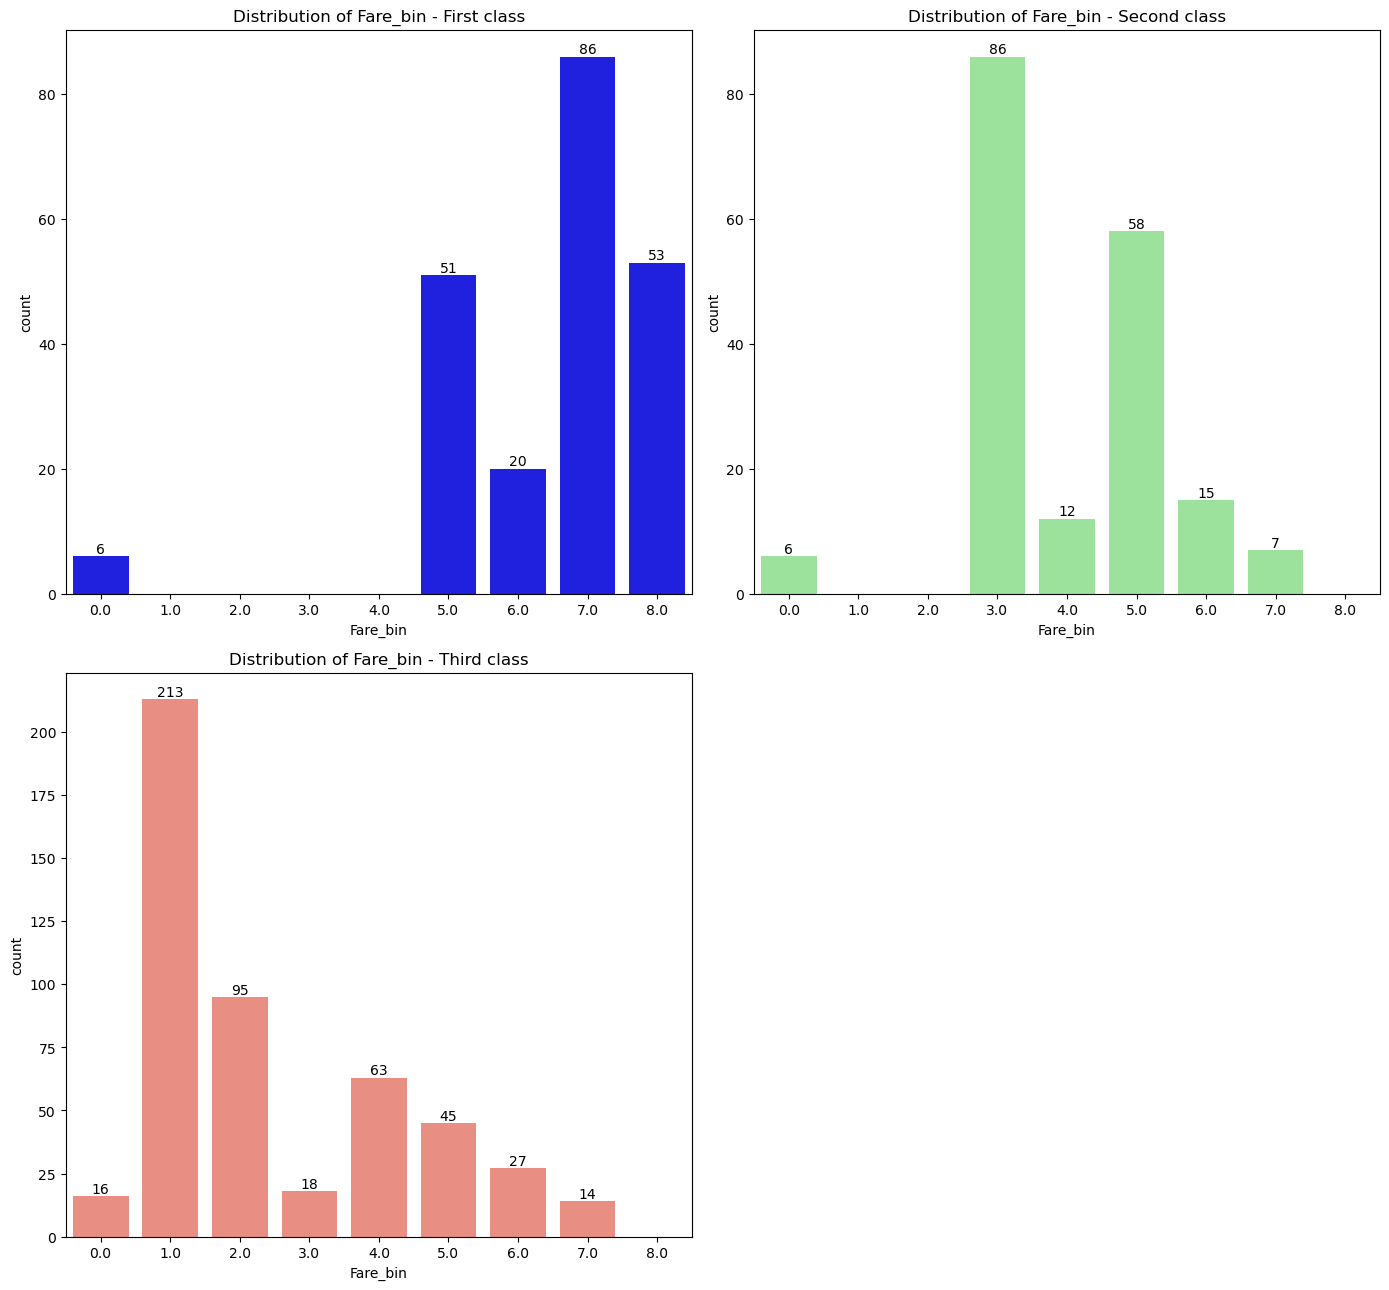

In [7]:
first_class = df["Pclass"].apply(lambda x: x == 1)
second_class = df["Pclass"].apply(lambda x: x == 2)
third_class = df["Pclass"].apply(lambda x: x == 3)

df_list = [first_class, second_class, third_class]
names = ["First class", "Second class", "Third class"]

plt.figure(figsize=(14, len(df_list) * 3 + 10))

# each graph have specific color
colors = ['blue', 'lightgreen', 'salmon']
for idx, (feature, name, color) in enumerate(zip(df_list, names, colors), 1):
    plt.subplot(len(df_list), 2, idx)
    sns.countplot(data=df[feature], x='Fare_bin', color=color)
    plt.title(f'Distribution of Fare_bin - {name}')
    ax = plt.gca()
    for container in ax.containers:
        ax.bar_label(container)    

plt.tight_layout()
plt.show()

Really interestingly, we could see that `Third class` passengers should be mostly in `low` and `medium` Fare_bin, while `First class` passengers should be mostly in `high` Fare_bin. But there are still some `Third class` passengers in `high` Fare_bin, which is quite strange.

In [8]:
df[df['Fare_bin'] == 7][df['Pclass'] == 3]

/tmp/ipykernel_7984/1825412487.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['Fare_bin'] == 7][df['Pclass'] == 3]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_bin,Fare_bin
74,75,1,3,"Bing, Mr. Lee",male,32.000000,0,0,1601,56.4958,S,3,7.0
159,160,0,3,"Sage, Master. Thomas Henry",male,4.574167,8,2,CA. 2343,69.5500,S,0,7.0
169,170,0,3,"Ling, Mr. Lee",male,28.000000,0,0,1601,56.4958,S,3,7.0
180,181,0,3,"Sage, Miss. Constance Gladys",female,29.699118,8,2,CA. 2343,69.5500,S,3,7.0
201,202,0,3,"Sage, Mr. Frederick",male,29.699118,8,2,CA. 2343,69.5500,S,3,7.0
324,325,0,3,"Sage, Mr. George John Jr",male,29.699118,8,2,CA. 2343,69.5500,S,3,7.0
509,510,1,3,"Lang, Mr. Fang",male,26.000000,0,0,1601,56.4958,S,2,7.0
643,644,1,3,"Foo, Mr. Choong",male,29.699118,0,0,1601,56.4958,S,3,7.0
692,693,1,3,"Lam, Mr. Ali",male,29.699118,0,0,1601,56.4958,S,3,7.0
792,793,0,3,"Sage, Miss. Stella Anna",female,29.699118,8,2,CA. 2343,69.5500,S,3,7.0


Having a look at this dataset, I realized that most of these passengers are actually families, since many passengers in this dataset had same family name, and the feature `SibSp` and `Parch` are quite high. The price that they had to pay for the tickets was likely influenced by their family size. Let's investigate the family size of the passengers to see if it has any impact on their survival.

### Family size

I decided to create a new feature `FamilySize`, which is the sum of `SibSp` and `Parch` plus 1 (the passenger itself).

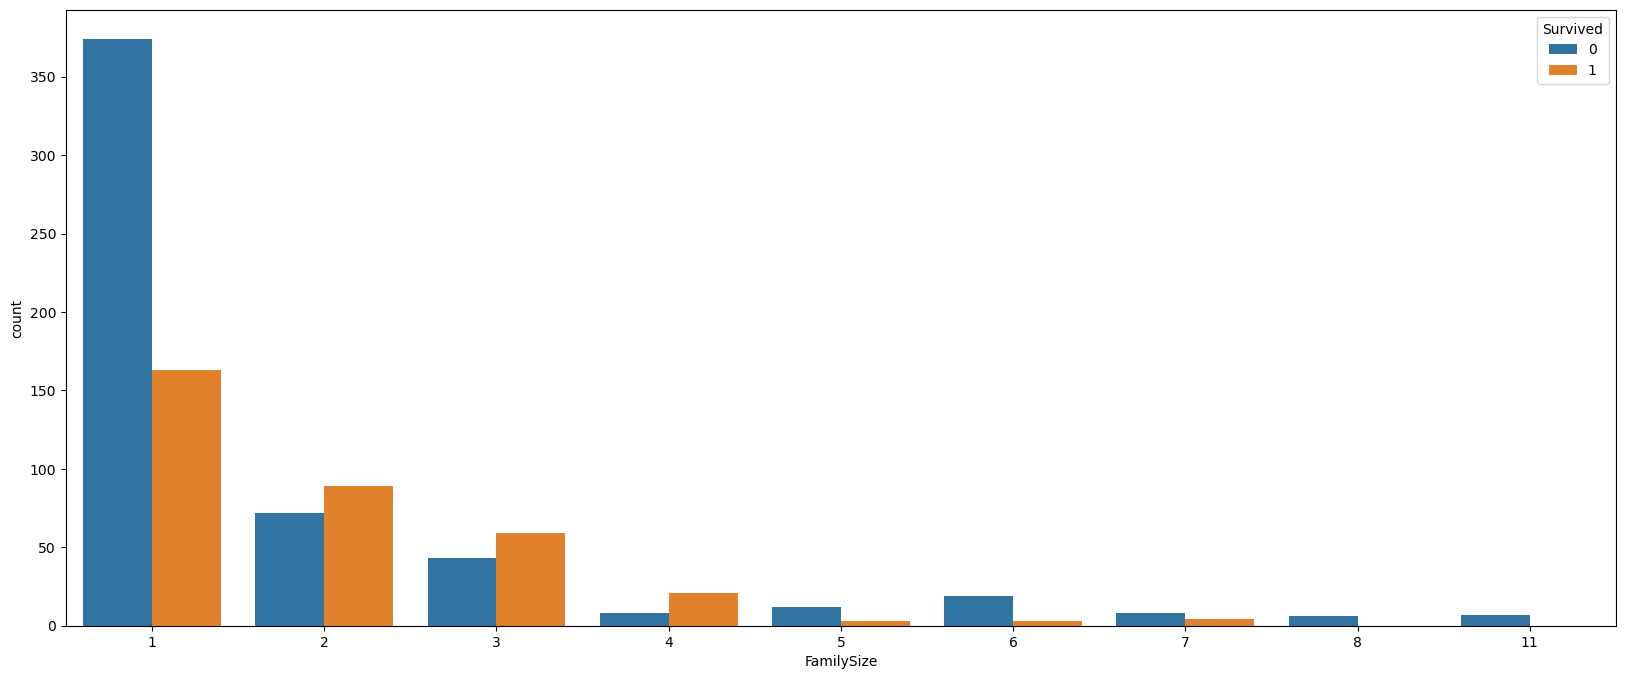

In [9]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1
fig, axs = plt.subplots(figsize=(20, 8))
sns.countplot(x='FamilySize', hue='Survived', data=df)
plt.show()

### Survivability base on FamilySize

In [10]:
for family_size in sorted(df['FamilySize'].unique()):
    survived = df[df['FamilySize'] == family_size][df['Survived'] == 1]
    survive_percentage = len(survived) / len(df[df['FamilySize'] == family_size]) * 100
    print(f'FamilySize {family_size}: {survive_percentage:.2f}% survived out of {len(df[df['FamilySize'] == family_size])} ({len(survived)} survived)')

FamilySize 1: 30.35% survived out of 537 (163 survived)
FamilySize 2: 55.28% survived out of 161 (89 survived)
FamilySize 3: 57.84% survived out of 102 (59 survived)
FamilySize 4: 72.41% survived out of 29 (21 survived)
FamilySize 5: 20.00% survived out of 15 (3 survived)
FamilySize 6: 13.64% survived out of 22 (3 survived)
FamilySize 7: 33.33% survived out of 12 (4 survived)
FamilySize 8: 0.00% survived out of 6 (0 survived)
FamilySize 11: 0.00% survived out of 7 (0 survived)


/tmp/ipykernel_7984/227718682.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  survived = df[df['FamilySize'] == family_size][df['Survived'] == 1]
/tmp/ipykernel_7984/227718682.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  survived = df[df['FamilySize'] == family_size][df['Survived'] == 1]
/tmp/ipykernel_7984/227718682.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  survived = df[df['FamilySize'] == family_size][df['Survived'] == 1]
/tmp/ipykernel_7984/227718682.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  survived = df[df['FamilySize'] == family_size][df['Survived'] == 1]
/tmp/ipykernel_7984/227718682.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  survived = df[df['FamilySize'] == family_size][df['Survived'] == 1]
/tmp/ipykernel_7984/227718682.py:2: UserWarning: Boolean Series key will be reindexed to m

To make things clearer, I will group the dataset by creating new feature `FamilyGroup` based on `FamilySize`.
- Small: FamilySize = 1
- Medium: FamilySize = 2 - 4
- Large: FamilySize = 5 - 7
- Very Large: FamilySize >= 8

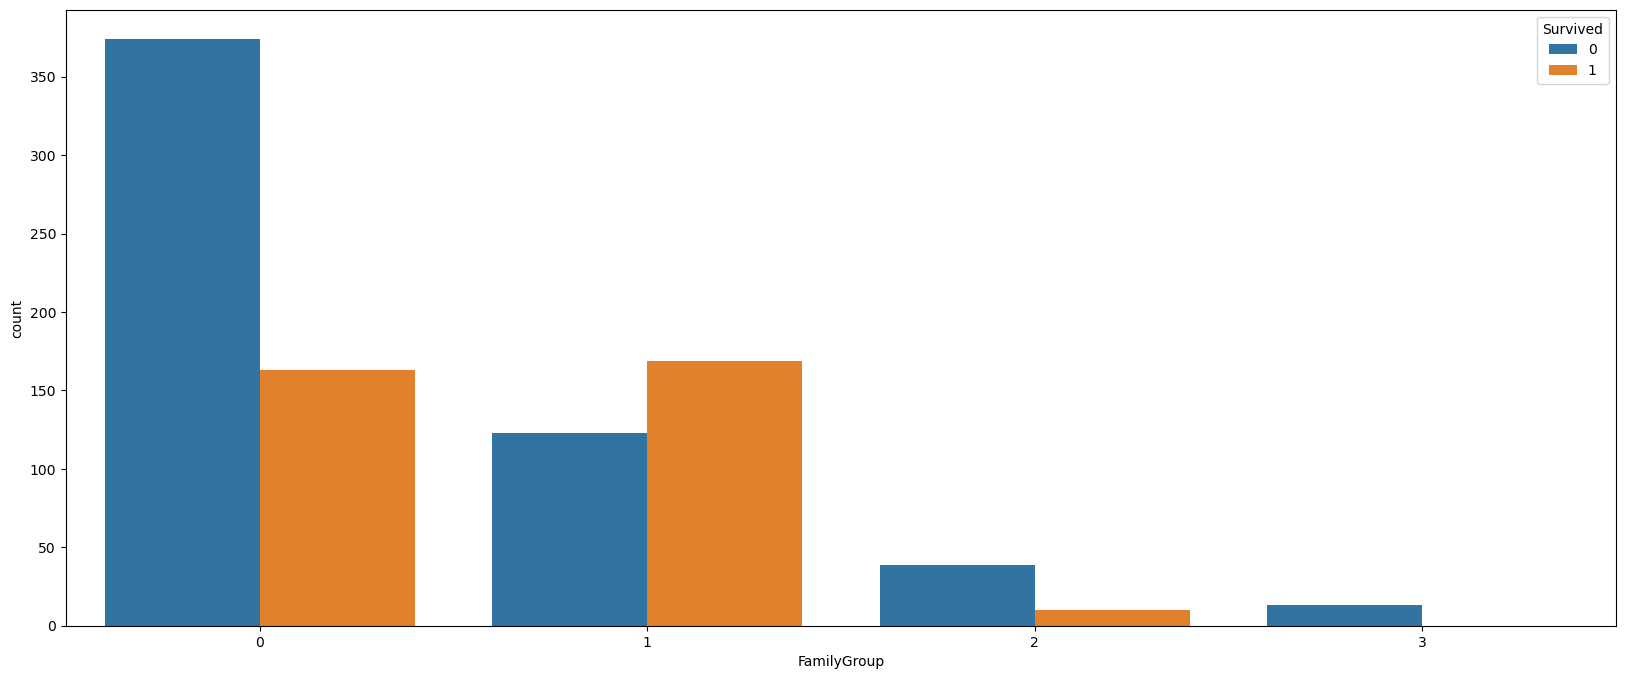

In [11]:
df['FamilyGroup'] = pd.cut(df['FamilySize'], bins=[0, 1, 4, 7, 20], labels=False)
df['FamilyGroup'] = df['FamilyGroup'].astype('category')

df_test['FamilyGroup'] = pd.cut(df_test['FamilySize'], bins=[0, 1, 4, 7, 20], labels=False)
df_test['FamilyGroup'] = df_test['FamilyGroup'].astype('category')

fig, axs = plt.subplots(figsize=(20, 8))
sns.countplot(x='FamilyGroup', hue='Survived', data=df)
plt.show()

In [12]:
for family_group in sorted(df['FamilyGroup'].unique()):
    survived = df[df['FamilyGroup'] == family_group][df['Survived'] == 1]
    survive_percentage = len(survived) / len(df[df['FamilyGroup'] == family_group]) * 100
    print(f'FamilyGroup {family_group}: {survive_percentage:.2f}% survived out of {len(df[df['FamilyGroup'] == family_group])} ({len(survived)} survived)')

FamilyGroup 0: 30.35% survived out of 537 (163 survived)
FamilyGroup 1: 57.88% survived out of 292 (169 survived)
FamilyGroup 2: 20.41% survived out of 49 (10 survived)
FamilyGroup 3: 0.00% survived out of 13 (0 survived)


/tmp/ipykernel_7984/4017964045.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  survived = df[df['FamilyGroup'] == family_group][df['Survived'] == 1]
/tmp/ipykernel_7984/4017964045.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  survived = df[df['FamilyGroup'] == family_group][df['Survived'] == 1]
/tmp/ipykernel_7984/4017964045.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  survived = df[df['FamilyGroup'] == family_group][df['Survived'] == 1]
/tmp/ipykernel_7984/4017964045.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  survived = df[df['FamilyGroup'] == family_group][df['Survived'] == 1]


From the result, we could see that:
- Alone passengers (FamilySize = 1) had a survival rate of 30.35% (163 out of 537).
- Small families (FamilySize = 2 - 4) had the highest survival rate of 57.88% (169 out of 292).
- Large families (FamilySize = 5 - 7) had a survival rate of 20.41% (10 out of 49).
- Very large families (FamilySize >= 8) had the lowest survival rate of 0% (0 out of 13).

## Feature Selection

In [13]:
df.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    category
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Embarked     891 non-null    category
 11  Age_bin      891 non-null    category
 12  Fare_bin     891 non-null    category
 13  FamilySize   891 non-null    int64   
 14  FamilyGroup  891 non-null    category
dtypes: category(7), float64(2), int64(4), object(2)
memory usage: 63.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (to

Currently, there are 15 features in the dataset (including `Survived` feature). We will have to select the most important features to train the model. After some discussion, and some testing, we finally decided to remove the following features:

- PassengerId: No correlation with any other variable.
- Cabin: Too many missing values and we could not find a way to fill them.
- Name: Not useful for prediction.
- Ticket: Not useful for prediction. (Even if we could extract some information from Ticket, it would be too complicated and not worth the effort)
- Fare: High correlation with Fare_bin, we will keep Fare_bin only.
- SibSp and Parch: High correlation with FamilySize, we will keep FamilySize only.

For sure, these removed features could be a useful information for prediction, but for now, we will not use them to train the model.

In [14]:
df = df.drop(['PassengerId', 'Name', 'Ticket', 'FamilyGroup', 'SibSp', 'Parch'], axis=1) # remove these feature because 1. not analyze it yet and 2. have other things to show that features (Pclass instead of fare and cabin and ticket)
df_test = df_test.drop(['PassengerId', 'Name', 'Ticket', 'FamilyGroup', 'SibSp', 'Parch'], axis=1)

In [15]:
# print all rows in df and df_test that have missing values
df.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    category
 1   Pclass      891 non-null    category
 2   Sex         891 non-null    category
 3   Age         891 non-null    float64 
 4   Fare        891 non-null    float64 
 5   Embarked    891 non-null    category
 6   Age_bin     891 non-null    category
 7   Fare_bin    891 non-null    category
 8   FamilySize  891 non-null    int64   
dtypes: category(6), float64(2), int64(1)
memory usage: 27.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Pclass      418 non-null    category
 1   Sex         418 non-null    category
 2   Age         418 non-null    float64 
 3   Fare        418 non-null    float64 
 4   Embarked 

In [16]:
tmp_train = df.copy()
tmp_test = df_test.copy()

tmp_train['Sex'] = tmp_train['Sex'].cat.codes
tmp_test['Sex'] = tmp_test['Sex'].cat.codes

tmp_train['Embarked'] = tmp_train['Embarked'].cat.codes
tmp_test['Embarked'] = tmp_test['Embarked'].cat.codes

tmp_train.info()
tmp_test.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    category
 1   Pclass      891 non-null    category
 2   Sex         891 non-null    int8    
 3   Age         891 non-null    float64 
 4   Fare        891 non-null    float64 
 5   Embarked    891 non-null    int8    
 6   Age_bin     891 non-null    category
 7   Fare_bin    891 non-null    category
 8   FamilySize  891 non-null    int64   
dtypes: category(4), float64(2), int64(1), int8(2)
memory usage: 27.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Pclass      418 non-null    category
 1   Sex         418 non-null    int8    
 2   Age         418 non-null    float64 
 3   Fare        418 non-null    float64 
 4   

In [17]:
df = tmp_train.copy()
df_test = tmp_test.copy()

## Save file

In [18]:
df.to_csv('./data/exp1_train.csv', index=False)
df_test.to_csv('./data/exp1_test.csv', index=False)
print("Successfully saved preprocessed data.")

Successfully saved preprocessed data.


# The end